In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa

from PIL import Image
import IPython.display as ipd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm
from utils import io, train
from utils import feature_engineering as fe

In [3]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

In [4]:
episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

In [5]:
episode_names

['Muppets-02-01-01', 'Muppets-02-04-04', 'Muppets-03-04-03']

# Get Kermit Pixel feature

In [33]:
feats = {}
for ep in episode_names:
    feat = fe.get_kermitian_pixels(video_paths[ep], ep)
    feats[ep] = feat

pickle.dump(feats, open("../data/features/kermit_pixels.pkl", "wb"))


Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38682, Codec = FMP4
Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38682, Codec = h264


  0%|          | 0/38682 [00:00<?, ?it/s]

100%|██████████| 38682/38682 [04:34<00:00, 140.71it/s]


Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38707, Codec = FMP4
Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38707, Codec = h264


100%|██████████| 38707/38707 [04:10<00:00, 154.72it/s]


Loaded video with resolution 704x544
FPS = 25.0, Frame Count = 38499, Codec = FMP4
Loaded video with resolution 704x544
FPS = 25.0, Frame Count = 38499, Codec = h264


100%|██████████| 38499/38499 [03:52<00:00, 165.46it/s]


# Preparation

Idea: use straight lines for the detection of Balcony Gentlemens, since Balcony has a very characteristical straight lines. Can we use Hough Transform in Sim1? 

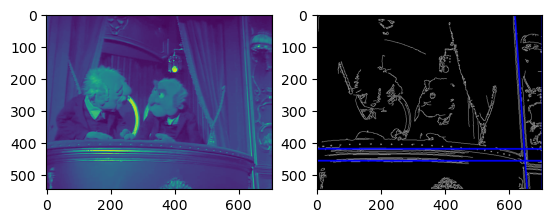

In [6]:
import math
import cv2 as cv
img_path = '../data/frames/Muppets-03-04-03/frame_09404.jpg' 
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)    
dst = cv.Canny(src, 50, 200, None, 3)
    
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLinesWithAccumulator(dst, 1, np.pi / 180, 200, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        if i == 3:
            break

plt.subplot(1,2,1)
plt.imshow(src)
plt.subplot(1,2,2)
plt.imshow(cdst)

In [7]:
# line_feat_dict = {}

# for ep in episode_names:
#     cap = io.load_video(video_paths[ep])
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     line_num_list = []  
#     max_votes_list = []
    
#     for i in range(frame_count):
#         _, frame = cap.read()

#         dst = cv2.Canny(frame, 50, 200, None, 3)
#         cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
#         cdstP = np.copy(cdst)
#         lines = cv2.HoughLinesWithAccumulator(dst, 0.5, np.pi / 180, 200, None, 0, 0)
        
#         line_feat = len(lines) if lines is not None else 0
#         max_votes = lines[0][0][2] if lines is not None else 0

#         line_num_list.append(line_feat)
#         max_votes_list.append(max_votes)

#     line_feat_dict[ep] = {}
#     line_feat_dict[ep]['num_lines'] =  np.array(line_num_list)[1:]
#     line_feat_dict[ep]['max_votes'] =  np.array(max_votes_list)[1:]

#     del line_num_list
#     del max_votes_list
#     cap.release()

Compute blobs:

In [14]:
radius_col = 2
n_max = 3
debug = False
white_params = {
    'mu_v': 200, 
    'sigma_v': 40, 
    'mu_h': 30, 
    'sigma_h': 30
}

radien_feat_dict = {}

for ep in episode_names:
    cap = io.load_video(video_paths[ep])
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    green_radien_list = []  
    white_radien_list = []
    
    for i in tqdm(range(frame_count)):
        _, image = cap.read()

        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if debug:
            plt.imshow(image_rbg)

        sigma = 7
        green_yellow = np.uint8([[[255*0.85, 255, 0]]])
        hsv_green_yellow = cv2.cvtColor(green_yellow, cv2.COLOR_RGB2HSV)
        mu = hsv_green_yellow[0, 0, 0]

        blob_list = fe.detect_blob(image_hsv, sigma, mu, debug=debug)
        blob_radius = blob_list[:, radius_col]
        biggest_radien_green = blob_radius[np.argsort(blob_radius)[-n_max:]]

        keypoints = fe.detect_blob_cv(image_gray, image, image_hsv, debug=debug, **white_params)
        k_radien = np.array([k.size for k in keypoints])
        biggest_radien_eyes = k_radien[np.argsort(k_radien)[-n_max:]]

    radien_feat_dict[ep] = {}
    radien_feat_dict[ep]['num_lines'] =  np.array(green_radien_list)[1:]
    radien_feat_dict[ep]['max_votes'] =  np.array(white_radien_list)[1:]

    del green_radien_list
    del white_radien_list
    cap.release()


Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38682, Codec = FMP4


  0%|          | 0/38682 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pickle.dump(radien_feat_dict, open("../data/features/radien_feat_dict.pkl", "wb"))

In [ ]:
img_path = '../data/frames/Muppets-03-04-03/frame_00000.jpg'
image = cv2.imread(img_path)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if debug:
    plt.imshow(image_rbg)

sigma = 7
green_yellow = np.uint8([[[255*0.85, 255, 0]]])
hsv_green_yellow = cv2.cvtColor(green_yellow, cv2.COLOR_RGB2HSV)
mu = hsv_green_yellow[0, 0, 0]

# blob_list = fe.detect_blob(image_hsv, sigma, mu, debug=debug)
# blob_radius = blob_list[:, radius_col]
# biggest_radien_green = blob_radius[np.argsort(blob_radius)[-n_max:]]

# keypoints = fe.detect_blob_cv(image_gray, image, image_hsv, debug=debug, **white_params)
# k_radien = np.array([k.size for k in keypoints])
# biggest_radien_eyes = k_radien[np.argsort(k_radien)[-n_max:]]

# Foreground mask based on optical flow

In [ ]:
for ep in episode_names:
        fe.create_foreground_masks_video(video_paths[ep])

In [14]:

ep1 = pickle.load(open("../data/features/Muppets-02-01-01_foreground.pkl", "rb"))
ep2 = pickle.load(open("../data/features/Muppets-02-04-04_foreground.pkl", "rb"))
ep3 = pickle.load(open("../data/features/Muppets-03-04-03_foreground.pkl", "rb"))
flow_features = {}
flow_features['Muppets-02-01-01'] = ep1
flow_features['Muppets-02-04-04'] = ep2
flow_features['Muppets-03-04-03'] = ep3
pickle.dump(flow_features, open("../data/features/flow_features.pkl", "wb"))


# Dominant colors

In [8]:
n_clusters = 5
batch_size = 2048
hue_feat_list = {}

for ep in episode_names:
    hue_feat_list[ep] = {}
    hue_arr = fe.get_dominant_colors(video_paths[ep], ep, n_clusters, batch_size, type='full')
    hue_feat_list[ep]['hue_list'] = hue_arr  

pickle.dump(hue_feat_list, open("../data/features/hue_feat_list_full.pkl", "wb"))

Loaded video with resolution 704x544
FPS = 25.0, Frame Count = 38499, Codec = FMP4
Loaded video with resolution 704x544
FPS = 25.0, Frame Count = 38499, Codec = h264


  0%|          | 0/38499 [00:00<?, ?it/s]

100%|██████████| 38499/38499 [38:24<00:00, 16.70it/s] 


In [ ]:
n_clusters = 5
batch_size = 2048
hue_feat_list = {}

for ep in episode_names:
    hue_feat_list[ep] = {}
    hue_arr = fe.get_dominant_colors(video_paths[ep], ep, n_clusters, batch_size, type='foreground')
    hue_feat_list[ep]['hue_list'] = hue_arr  

pickle.dump(hue_feat_list, open("../data/features/hue_feat_list_foreground.pkl", "wb"))

In [7]:
n_clusters = 5
batch_size = 2048
hue_feat_list = {}

for ep in episode_names:
    hue_feat_list[ep] = {}
    hue_arr = fe.get_dominant_colors(video_paths[ep], ep, n_clusters, batch_size, type='background')
    hue_feat_list[ep]['hue_list'] = hue_arr  

pickle.dump(hue_feat_list, open("../data/features/hue_feat_list_background.pkl", "wb"))

AttributeError: module 'utils.feature_engineering' has no attribute 'get_dominant_colors'

Compute audio features:

In [ ]:
ep_dfs = []
for ep in episode_names:
    rec, sr = librosa.load(video_paths[ep], sr=None)

    frame_size_ms = 400
    hop_length = int(1/25 * sr)
    frame_length = int(frame_size_ms / 1000 * sr)
    
    desired_len = len(gt_df[gt_df.episode==ep])
    zcr = librosa.feature.zero_crossing_rate(y=rec, frame_length=frame_length, hop_length=hop_length)
    zcr = np.pad(zcr, pad_width=((0, 0), (0, desired_len - zcr.shape[1]))).flatten()

    rms = librosa.feature.rms(y=rec, frame_length=frame_length, hop_length=hop_length)
    rms = np.pad(rms, pad_width=((0, 0), (0, desired_len - rms.shape[1]))).flatten()

    mfcc = librosa.feature.mfcc(y=rec, sr=sr, n_fft=frame_length, hop_length=hop_length)
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, desired_len - mfcc.shape[1])))

    ep_df = pd.DataFrame()

    ep_df['zcr'] = zcr
    ep_df['rms'] = rms
    
    for i in range(mfcc.shape[0]):
        ep_df[f'mfcc_{i}'] = mfcc[i]
    
    ep_df['episode'] = ep
    ep_dfs.append(ep_df)

feat_df = pd.concat(ep_dfs)

Compute feature dicts:
- Dominant Color
- Line Features

In [ ]:
color_feat_dict = fe.get_dominant_color(episode_names, video_paths, path_to_save=None)

Add dominant color to the dataframe: 

In [ ]:
for ep in episode_names:
    for i in range(color_feat_dict[ep].shape[1]):
        feat_df.loc[feat_df['episode'] == ep, f'dc_{i}'] = color_feat_dict[ep][:, i]

Add line features to the dataframe:

In [ ]:
for ep in episode_names:
    for line_feat_type in ['num_lines', 'max_votes']:
        feat_df.loc[feat_df['episode'] == ep, line_feat_type] = line_feat_dict[ep][line_feat_type]

In [ ]:
for ep in episode_names:
    current_hue_feat_list = hue_feat_list[ep]['hue_list']
    for i, col_name in enumerate(['percentage', 'hue']):
        for k in range(current_hue_feat_list.shape[1]):
            feat_df.loc[feat_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

In [ ]:
feat_df

In [ ]:
# Code to listen to audio
# ipd.Audio(rec, rate=sr)

# Training & Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Inner CV

### Kermit

In [ ]:
train_configs = [
    {
        'train_cols': ['zcr'],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['rms'],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)] + [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    }
]

In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)

In [ ]:
eval_df

In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_2_to_1(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)
eval_df

In [ ]:
eval_df.to_csv("../data/eval/DT_Kermit.csv")

In [ ]:
train_config = {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
}

config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)
eval_df

## Gents

In [ ]:
train_configs = [
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)] + ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)] + ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    }
]

In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_2_to_1(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)

In [ ]:
eval_df

In [ ]:
eval_df.to_csv("../data/eval/DT_Gents.csv")

In [ ]:
# eval_dfs = []
# model_infos = {}

# for train_config in train_configs:
#     config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
#     eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

#     eval_dfs.append(eval_df)
#     model_infos[config] = model_info

# eval_df = pd.concat(eval_dfs)

In [ ]:
eval_df

In [ ]:
train_config = {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
}

config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)
eval_df

# Stuff

In [ ]:
# episode_id = 2
# cap = io.load_video(video_paths[episode_names[episode_id]])

# frames = []
# for i in range(1000):
#     ret, frame = cap.read()
#     frames.append(frame)

# img_orig, color = get_dominant_color(frames[942])

# dominant_color_normalized = [x/255 for x in color]

# # Create a new image of size 100x100 pixels and set all its pixels to the dominant color
# image = np.full((100, 100, 3), dominant_color_normalized)

# # Display the image
# plt.imshow(image)

# plt.imshow(img_orig)

In [ ]:
%ls

In [ ]:
%ls '../data/frames/Muppets-02-04-04/'

In [ ]:
os.path.exists('../data/frames/Muppets-02-04-04/frame_06246.jpg')

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img_path = '../data/frames/Muppets-03-04-03/frame_09302.jpg' 
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
img[abs(sobely) < 100] = 0.0
plt.subplot(2,2,4),plt.imshow(img)

In [ ]:
import math
import cv2 as cv
img_path = '../data/frames/Muppets-03-04-03/frame_09404.jpg' 
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)    
dst = cv.Canny(src, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)


lines = cv.HoughLinesWithAccumulator(dst, 1, np.pi / 180, 200, None, 0, 0)

pt1s = []
pt2s = []

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pt1s.append(pt1)
        pt2s.append(pt2)
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        if i == 3:
            break


# linesP = cv.HoughLinesP(dst, 0.5, np.pi / 10, 150, None, 50, 10)

print(len(linesP))

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

plt.subplot(1,3,1)
plt.imshow(src)
plt.subplot(1,3,2)
plt.imshow(cdst)
plt.subplot(1,3,3)
plt.imshow(cdstP)

In [ ]:
import seaborn as sns
plt.hlines([p[0] for p in pt1s], [p[1] for p in pt1s], c='orange')
plt.hlines([p[0] for p in pt2s], [p[1] for p in pt2s], c='blue')